In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# for cross validation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# for metrics
from sklearn.metrics import r2_score,mean_squared_error
# save model
from joblib import dump, load

In [2]:
# import data
dataset_url = r"C:\Users\gonza\OneDrive\Documentos\datascience-thebridge-master\ejercicios gonzalo\DATA\winequality-red.csv"
data = pd.read_csv(dataset_url,sep=";")
data.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


All of the features are numeric, which is convenient. However, they have some very different scales, so let's make a mental note to standardize the data later.

In [3]:
#Split data into training and test sets.
X = data.drop("quality",axis=1)
Y = data.quality

In [4]:
# usamos stratify para preservar las proporciones de los valores ( ver value counts en quality)
X_train, X_test, y_train,y_test = train_test_split(X,Y, test_size=0.2,random_state=0,stratify=Y)

* Fit the transformer on the training set (saving the means and standard deviations)
* Apply the transformer to the training set (scaling the training data)
* Apply the transformer to the test set (using the same means and standard deviations)

In [15]:
Y.describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [10]:
# vamos a hacer tres grupos de vinos (malos, medios,muy buenos)
np.sort(Y.unique())

array([3, 4, 5, 6, 7, 8], dtype=int64)

In [5]:
def label_wine(Y):
    bins = (2, 6.5, 8)
    group_names = ['bad', 'good']    
    df = pd.cut(Y.astype("float"),bins=bins,labels=group_names)
    le = preprocessing.LabelEncoder()
    return le.fit_transform(df)


In [6]:
y_train_label = label_wine(y_train)

In [7]:
y_test_label = label_wine(y_test)

In [10]:
# modelo baseline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def baseline(X_train,y_train_label):
    models = {"rid":RidgeClassifier(),"log":LogisticRegression(random_state=0,                  
    class_weight="balanced"),"rdf":RandomForestClassifier(),"kne":KNeighborsClassifier(),"svc":SVC()}
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    kfold = KFold(n_splits=10, random_state=100)
    for key,model_kfold in models.items():        
        results_kfold = cross_val_score(model_kfold, X_train_scaled, y_train_label, cv=kfold)
        print(f"Accuracy {key}: {results_kfold.mean()*100.0}")

In [32]:
dict_prueba = {"rid":RidgeClassifier(),"log":LogisticRegression(random_state=0,class_weight="balanced"),"kne":KNeighborsClassifier(),"svc":SVC()}

In [42]:
for key,value in dict_prueba.items():
    print(key,value)
  

rid RidgeClassifier()
log LogisticRegression(random_state=0)
kne KNeighborsClassifier()
svc SVC()


In [11]:
baseline(X_train,y_train_label)

Accuracy rid: 87.02202263779529
Accuracy log: 79.6751968503937
Accuracy rdf: 91.78949311023622
Accuracy kne: 87.33452263779527
Accuracy svc: 88.97453248031496


In [12]:
# despues de esta baseline vemos que random forest va bien, ahora buscaremos mejores hiperparametros con randomsearch
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 300, 500]
max_depth = [5, 8, 15,30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10,50] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

def final_model_get_params(X_train,y_train_label):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, 
                        n_jobs = -1)
    bestF = gridF.fit(X_train_scaled,y_train_label)
    print(f"los mejores parametros: {bestF.best_params_}")
    print(f"los mejores resultados: {bestF.best_score_}")
    

In [14]:
final_model_get_params(X_train,y_train_label)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.8min finished
los mejores parametros: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
los mejores resultados: 0.9116520617328745


In [78]:
def final_model__best_params(X_train,y_train_label):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    gridF = RandomForestClassifier(max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=500,random_state=0,n_jobs=1)
    gridF.fit(X_train_scaled,y_train_label)
    print(f"score: {gridF.score(X_train_scaled,y_train_label)}")

In [79]:
# tenemos que revisar esto porque nos da overfitting
final_model__best_params(X_train,y_train_label)

score: 0.9953088350273651


In [80]:
def final_model_predict(X_train,X_test,y_train_label,y_test_label):
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    gridF = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=1200,random_state=0,n_jobs=1)
    gridF.fit(X_train_scaled,y_train_label)
    print(f"score: {gridF.score(X_train_scaled,y_train_label)}")
    print(f"score: {gridF.score(X_test_scaled,y_test_label)}")
    

In [81]:
final_model_predict(X_train,X_test,y_train_label,y_test_label)

score: 0.9953088350273651
score: 0.9125


In [30]:
from sklearn.metrics import classification_report
def final_model_predict_classification(X_train,X_test,y_train_label,y_test_label):
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    gridF = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=2,max_features=4, n_estimators=500,random_state=0,n_jobs=1,class_weight="balanced")
    gridF.fit(X_train_scaled,y_train_label)
    print(f"score with train data: {gridF.score(X_train_scaled,y_train_label)}")    
    print(classification_report(y_test_label,gridF.predict(X_test_scaled)))

In [31]:
final_model_predict_classification(X_train,X_test,y_train_label,y_test_label)

score with train data: 0.9984362783424551
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       277
           1       0.72      0.49      0.58        43

    accuracy                           0.91       320
   macro avg       0.82      0.73      0.77       320
weighted avg       0.90      0.91      0.90       320



In [32]:
def final_model_cv(X_train,X_test,y_train_label,y_test_label):
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    gridF = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=2,max_features=4, n_estimators=500,random_state=0,n_jobs=1,class_weight="balanced")   
    kf = KFold(shuffle=True, n_splits=10,random_state=0)
    cross_model = cross_val_score(gridF,X_train_scaled,y_train_label,cv=kf,scoring='accuracy',n_jobs=1)    
    print(f"cross model: {cross_model}")    
    print(f"cross 5 model mean: {np.mean(cross_model)}")    
    

In [33]:
final_model_cv(X_train,X_test,y_train_label,y_test_label)

cross model: [0.8828125  0.921875   0.921875   0.8828125  0.890625   0.953125
 0.9140625  0.8828125  0.875      0.94488189]
cross 5 model mean: 0.906988188976378


In [ ]:
### pendiente clasification report, ver overfiting, otras metricas de clasficacion, kmeans para ver grupos de vinos (como hizo el profe); ver f1 y clasification report // ver tunear balanced ¡¡¡

###  ojo la parte de abajo son pruebas , hay que continuar desarollando lo de arriba (ojo para hacer predict tenemos que hacer label encoder y scaled como hemos hecho con train)

In [10]:
# fitting the transformer
scaler = preprocessing.StandardScaler().fit(X_train)
# apply to training set
X_train_scaled = scaler.transform(X_train)

In [11]:
#Note how we're taking the scaler object and using it to transform the training set. Later, we can transform the test set using the exact same means and standard deviations used to transform the training set:
#  we're transforming the test set using the means from the training set, not from the test set itself.
X_test_scaled = scaler.transform(X_test)

In practice, when we set up the cross-validation pipeline, we won't even need to manually fit the Transformer API. Instead, we'll simply declare the class object, like so:

pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))

### Declare hyperparameters to tune.
There are two types of parameters we need to worry about: model parameters and hyperparameters. Models parameters can be learned directly from the data (i.e. regression coefficients), while hyperparameters cannot.

In [12]:
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

### cross validation
This is one of the most important skills in all of machine learning because it helps you maximize model performance while reducing the chance of overfitting.

In [13]:
pipeline = make_pipeline(preprocessing.StandardScaler(), RandomForestRegressor(n_estimators=100))
clf = GridSearchCV(pipeline,hyperparameters,cv=10)

# fit and tune model
clf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [None, 5, 3, 1],
                         'randomforestregressor__max_features': ['auto', 'sqrt',
                                                                 'log2']})

In [14]:
clf.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'sqrt'}

In [15]:
print(clf.refit)

True


In [17]:
# Evaluate model pipeline on test data.
y_predict = clf.predict(X_test)

In [18]:
print(r2_score(y_test,y_predict))

0.5029679762697501


In [19]:
print(mean_squared_error(y_test,y_predict))

0.3207215625


In [25]:
### intentemos mejorar el modelo
corr = data.corr()
corr.iloc[:,-1].sort_values(ascending=False).to_frame().style.background_gradient(cmap='PuRd')

,quality
quality,1.000000
alcohol,0.476166
sulphates,0.251397
citric acid,0.226373
fixed acidity,0.124052
residual sugar,0.013732
free sulfur dioxide,-0.050656
pH,-0.057731
chlorides,-0.128907
density,-0.174919


In [26]:
corr.style.background_gradient(cmap='Blues')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [27]:
# vemos cif para ver si hay multicolanierda vif = 1/(1-R2)
vif = 1/(1-r2_score(y_test,y_predict))
vif


2.0119427969549135

In [ ]:
### ojo podemos hacer pca pero con menos grupos (ver qcut)

In [66]:
# podemos hacer un plot para ver como quedan
from sklearn.decomposition import PCA
# primero tenemos que standarizar
X_scaled = preprocessing.StandardScaler().fit_transform(X.copy())
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

In [67]:
principaldf = pd.DataFrame(data=principalComponents,columns=[1,2])

In [68]:
# final df
finaldf = pd.concat([principaldf,data[["quality"]]],axis=1)
finaldf.head(3)

,1,2,quality
0,-1.619530,0.450950,5
1,-0.799170,1.856553,5
2,-0.748479,0.882039,5


In [70]:
#Making binary classificaion for the response variable.
#Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
finaldf['quality'] = pd.cut(finaldf['quality'], bins = bins, labels = group_names)

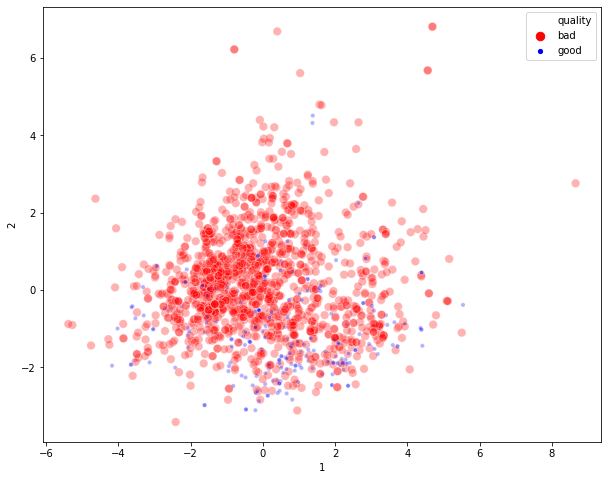

In [74]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=1,y=2,data=finaldf,hue="quality",alpha=0.3,palette=["r","b"],size="quality")

In [ ]:
### ver bien gridsearchv y resolver este ejercicio con clasificacion (es mejor usar todos los modelos como baseline y despues gridsearch para optimizarlo ¡¡)
https://stackoverflow.com/questions/48726695/error-when-using-scikit-learn-to-use-pipelines

https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine
